In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns

# CatBoost
# from catboost import CatBoostRegressor

# PyTorch
import torch
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Utility
import os
import random
import warnings; warnings.filterwarnings("ignore")
from tqdm import tqdm
from itertools import combinations,product
import sklearn

pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

### Setting universal random_state
np.random.seed(142)
random.seed(142)
sklearn.utils.check_random_state(142)
torch.manual_seed(142)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cuda


### 파일경로 설정
- stock_filepath
- total_filepath
- testfile

In [3]:
class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df
    
stock_filepath = '../../data/stock_price/netflix_60.csv' # 각자 파일 경로 설정
news_filepath = '../../data/scraping/news_processed_filtered_2.csv'
# stock_filepath = '/kaggle/input/netflix-stock-prediction/netflix_60.csv' # 각자 파일 경로 설정
# news_filepath = '/kaggle/input/netflix-stock-prediction/news_processed_filtered_2.csv'
# stock_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/netflix_60.csv'
# news_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/news_processed_filtered_2.csv'
loader = PrepareData(stock_filepath, news_filepath)
stock_df, news_df=loader.load_data() # >> 감성분석 미포함으로 모델 돌릴 땐 stock_df 바로 사용하면 됨
total_df = loader.merging(stock=stock_df, news=news_df) # 주식데이터셋에 감성분석,토픽 포함시킨 전체 데이터셋
testfile = '../../data/test.csv'
# testfile = '/kaggle/input/netflix-stock-prediction/test.csv'
test_df = pd.read_csv(testfile)

stock_df.index = stock_df["Date"]
stock_df.drop(columns = "Date", inplace = True)
stock_df["PINS"].fillna(24.99, inplace = True)
total_df.index = total_df["Date"]
total_df.drop(columns = "Date", inplace = True)
total_df["PINS"].fillna(24.99, inplace = True)

In [4]:
 result_df = pd.DataFrame({
    'data':[0],
    'target':[0],
    'seq_size':[0],
    'pred_size':[0],
    'batch_size':[0],
    'hidden_size':[0],
    'best_val_loss':[0],
    'mean_error_ratio':[0]
})
result_df

,data,target,seq_size,pred_size,batch_size,hidden_size,best_val_loss,mean_error_ratio
0,0,0,0,0,0,0,0,0


# 파라미터 설정

In [5]:
best_losses = []
mean_error_ratios = []

datanames = ['total_df']#,'stock_df']

for dataname in datanames:
    ### Choose dataset & Hyperparameter setting
    if dataname=='total_df':
        data = total_df
    else:
        data = stock_df
    MODEL = 'Transformer'                 # 'LSTM' / 'GRU' / 'Transformer'
    TARGET = "1d_ROC"                      # "Close" / "1d_ROC"
    SEQ_SIZE = 30                         # 30 / 60 / 120
    PRED_SIZE = 10
    BATCH_SIZE = 1                        # 1 / 4 / 8
    HIDDEN_SIZE = 64                      # 64 / 128
    EPOCHS = 1000
    
    filename = f'{MODEL}_{dataname}_{TARGET}_seq{SEQ_SIZE}_batch{BATCH_SIZE}_hidden{HIDDEN_SIZE}'

    print(f'🔸START - {filename}🔸')
    ### Make train datset

    def split_xy(dataset, time_steps, y_column):
        x, y = list(), list()
        for i in range(len(dataset)):
            x_end_number = i + time_steps
            y_end_number = x_end_number + y_column

            if y_end_number > len(dataset):
                break
            tmp_x = dataset.iloc[i:x_end_number, :]  # Adjusted for Pandas
            tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
            x.append(tmp_x.values)  # Convert to numpy array
            y.append(tmp_y.values)  # Convert to numpy array

        return np.array(x), np.array(y)

    X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
#     print(X[0,:],"\n", y[0])
#     print("X size : ", X.shape)
#     print("y size : ", y.shape)

    ### Define X_test

    X_test = data.tail(SEQ_SIZE).values.reshape(1, SEQ_SIZE, data.shape[1])
#     print(X_test)
#     print("X_test size : ", X_test.shape)

    ### Standardization

    from sklearn.preprocessing import StandardScaler

    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(X.shape[0], SEQ_SIZE, data.shape[1])

    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
    X_test = scaler.transform(X_test)
    X_test = X_test.reshape(X_test.shape[0], SEQ_SIZE, data.shape[1])

#     print("X size : ", X.shape)
#     print("X_test size : ", X_test.shape)

    ### Split train-validation dataset

    # to DataLoader
    import torch
    from torch.utils.data import Dataset, DataLoader, TensorDataset
    from sklearn.model_selection import train_test_split

    for trial in tqdm(list(range(1,11))):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1, test_size = 0.2)

        # to tensor
        X_train = torch.tensor(X_train.astype(np.float32), dtype = torch.float32)
        X_valid = torch.tensor(X_valid.astype(np.float32), dtype = torch.float32)
        y_train = torch.tensor(y_train.astype(np.float32), dtype = torch.float32)
        y_valid = torch.tensor(y_valid.astype(np.float32), dtype = torch.float32)

        # to DataLoader
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = BATCH_SIZE, shuffle = True)
        val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size = BATCH_SIZE, shuffle = False)

        ### Initialize Model
        try:
            for param in model.parameters():
                if param.requires_grad:
                    if len(param.shape) > 1:
                        init.xavier_uniform_(param)
                    else:
                        init.zeros_(param)
        except:
            try:
                model.reset_parameters()
            except:
                pass

        ### Modeling

        import copy
        class EarlyStopping:
            def __init__(self, patience = 5, min_delta = 0, restore_best_weights = True):
                self.patience = patience
                self.min_delta = min_delta
                self.restore_best_weights = restore_best_weights
                self.best_model = None
                self.best_loss = None
                self.counter = 0
                self.status = ""

            def __call__(self, model, val_loss):
                if self.best_loss is None:
                    self.best_loss = val_loss
                    self.best_model = copy.deepcopy(model.state_dict())
                elif self.best_loss - val_loss >= self.min_delta:
                    self.best_model = copy.deepcopy(model.state_dict())
                    self.best_loss = val_loss
                    self.counter = 0
                    self.status = f"Improvement found, counter reset to {self.counter}"
                else:
                    self.counter += 1
                    self.status = f"No improvement in the last {self.counter} epochs"
                    if self.counter >= self.patience:
                        self.status = f"Early stopping triggered after {self.counter} epochs."
                        if self.restore_best_weights:
                            model.load_state_dict(self.best_model)
                        return True
                return False

        # Positional Encoding for Transformer
        class PositionalEncoding(nn.Module):
            def __init__(self, d_model, dropout=0.1, max_len=1000):
                super(PositionalEncoding, self).__init__()
                self.dropout = nn.Dropout(p=dropout)

                pe = torch.zeros(max_len, d_model)
                position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
                div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
                pe[:, 0::2] = torch.sin(position * div_term)
                pe[:, 1::2] = torch.cos(position * div_term)
                pe = pe.unsqueeze(0).transpose(0, 1)
                self.register_buffer('pe', pe)

            def forward(self, x):
                x = x + self.pe[:x.size(0), :]
                return self.dropout(x)

        # Model definition using Transformer
        class TransformerModel(nn.Module):
            def __init__(self, input_dim, d_model, nhead=4, num_layers=2, dropout=0.2, output_size=10):
                super(TransformerModel, self).__init__()

                self.encoder = nn.Linear(input_dim, d_model,bias=True)
                self.pos_encoder = PositionalEncoding(d_model, dropout)
                encoder_layers = nn.TransformerEncoderLayer(d_model, nhead,bias=True)
                self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
                self.decoder = nn.Linear(d_model, output_size,bias=True)

            def forward(self, x):
                x = self.encoder(x)
                x = self.pos_encoder(x)
                x = self.transformer_encoder(x)
                x = self.decoder(x[:, -1, :])
                return x

        class RMSELoss(nn.Module):
            def __init__(self):
                super(RMSELoss,self).__init__()
                self.mse = nn.MSELoss()

            def forward(self,yhat,y):
                return torch.sqrt(self.mse(yhat,y))

        globals()[f'model{trial}'] = TransformerModel(X_train.shape[2],
                                d_model = HIDDEN_SIZE,
                                output_size = PRED_SIZE).to(device)
        criterion = RMSELoss()
        optimizer = optim.Adam(globals()[f'model{trial}'].parameters(), lr = 0.001)
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 20, verbose = True)

        ### RUN!!

        epoch_counter = 0
        patience = 30
        best_loss = float('inf')
        done = False
        es = EarlyStopping(patience=patience)
        tr_losses_fp, val_losses_fp = [],[]

        while not done and epoch_counter<EPOCHS:
            epoch_counter+=1

            # train
            globals()[f'model{trial}'].train()
            train_losses = []
            for batch in train_loader:
                x_batch, y_batch = batch
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                output = globals()[f'model{trial}'](x_batch)
                loss = criterion(output,y_batch)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            train_loss = np.mean(train_losses)
            tr_losses_fp.append(train_loss)

            # validation
            globals()[f'model{trial}'].eval()
            val_losses = []
            with torch.no_grad():
                for batch in val_loader:
                    x_batch, y_batch = batch
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    output = globals()[f'model{trial}'](x_batch)
                    loss = criterion(output, y_batch)
                    val_losses.append(loss.item())
            val_loss = np.mean(val_losses)
            val_losses_fp.append(val_loss)
            scheduler.step(val_loss)

            if es(globals()[f'model{trial}'], val_loss):
                done = True

            if val_loss < best_loss:
                best_loss = val_loss

            if epoch_counter%20 == 0:
                print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        print(f"Best validation loss : {best_loss}")
        best_losses.append(best_loss)
        
        ### Visualize train-validation loss

#         plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
#         plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
#         plt.legend()
#         # plt.show()
#         plt.savefig(f'../../plots/train_val_loss_2/{filename}.png')
#         plt.clf()
        globals()[f'train_losses_{trial}']=tr_losses_fp
        globals()[f'val_losses_{trial}']=val_losses_fp

        ### Prediction

        # evaluation
        globals()[f'model{trial}'].eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test.astype(np.float32), dtype = torch.float32,device=device)
            pred = globals()[f'model{trial}'](X_test_tensor)

        pred = pred.to('cpu').detach().numpy()
        # print(pred)

        if TARGET == "1d_ROC" :
            endPrice = data['Close'].iloc[-1]
            pred_close = []

            for i in pred[0] :
                endPrice = endPrice + endPrice*0.01*i
                pred_close.append(endPrice)

            pred = np.array(pred_close).reshape(1, PRED_SIZE)
        #     pred
        else :
            pass

        globals()[f'pred_{trial}'] = pred
        
        # pred_length = len(np.reshape(pred, (-1)))
        # pred_indices = list(range(pred_length))
        # plt.plot(pred_indices, np.reshape(pred, (-1)), color='red', alpha=0.6, label='Prediction')
        # plt.legend()

        # plt.show()

        ### Evaluation

        # Label
#         testfile = '../../data/test.csv'
#         test_df = pd.read_csv(testfile)
#         label = pd.read_csv(testfile) # 각자 test.csv 파일 경로
        label = test_df.copy()
        label = np.array(label.head(PRED_SIZE)["Close Price"])

        # Prediction
        pred = np.array(pred).reshape(PRED_SIZE)

        # 날짜 데이터
        period = test_df["Date"].copy()
        period = [d for d in period.head(PRED_SIZE)]

        # 오차율 계산
        error_rate = np.abs((label - pred) / label) * 100

        # 시각화
#         plt.figure(figsize=(12, 6))
#         plt.plot(period, label, marker='o', color='blue', label='Actual Close Price')
#         plt.plot(period, pred, marker='x', color='red', linestyle='--', label='Predicted Close Price')

#         # 오차율을 각 포인트에 텍스트로 표시
#         for date, lbl, prd, err in zip(period, label, pred, error_rate):
#             plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

#         plt.xticks(rotation = 45)  # 날짜 레이블 회전
#         plt.xlabel('Date')
#         plt.ylabel('Close Price')
#         plt.title(f'model = LSTM, data = {dataname}, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}')
#         plt.legend()
#         plt.tight_layout()  # 레이아웃 조정
#         # plt.show()
#         plt.savefig(f'../../plots/results_2/{filename}.png')
#         plt.clf()

        # 오차율을 출력
        error_rate_dict = dict(zip(period, error_rate))
        # error_rate_dict

        # 평균 오차율 계산
        average_error_rate = np.mean(error_rate)
        
        print(f"Average Error Rate: {average_error_rate:.2f}%")
        mean_error_ratios.append(average_error_rate)
        
        ### Save results to a DataFrame
#         temp_df = pd.DataFrame({
#             'data':[dataname],
#             'target':[TARGET],
#             'seq_size':[SEQ_SIZE],
#             'pred_size':[PRED_SIZE],
#             'batch_size':[BATCH_SIZE],
#             'hidden_size':[HIDDEN_SIZE],
#             'best_val_loss':[best_loss],
#             'mean_error_ratio':[average_error_rate]
#         })

#         result_df = pd.concat([result_df,temp_df],axis=0)
print('🔸END🔸')

🔸START - Transformer_total_df_1d_ROC_seq30_batch1_hidden64🔸


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 20/1000, Train Loss: 2.5262, Validation Loss: 2.3294
Epoch 40/1000, Train Loss: 2.5036, Validation Loss: 2.3084
Epoch 60/1000, Train Loss: 2.4955, Validation Loss: 2.3053
Epoch 00071: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.4848, Validation Loss: 2.2977
Epoch 00093: reducing learning rate of group 0 to 1.0000e-05.
Epoch 100/1000, Train Loss: 2.4824, Validation Loss: 2.2969


 10%|███████▉                                                                       | 1/10 [26:00<3:54:02, 1560.28s/it]

Best validation loss : 2.2957638069743016
Average Error Rate: 2.04%
Epoch 20/1000, Train Loss: 2.5106, Validation Loss: 2.3208
Epoch 40/1000, Train Loss: 2.5028, Validation Loss: 2.3108
Epoch 60/1000, Train Loss: 2.4961, Validation Loss: 2.3085
Epoch 00064: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.4783, Validation Loss: 2.3049
Epoch 00090: reducing learning rate of group 0 to 1.0000e-05.


 20%|███████████████▊                                                               | 2/10 [48:16<3:10:27, 1428.49s/it]

Best validation loss : 2.302576582451336
Average Error Rate: 1.72%
Epoch 20/1000, Train Loss: 2.5126, Validation Loss: 2.3179
Epoch 40/1000, Train Loss: 2.4940, Validation Loss: 2.3024
Epoch 60/1000, Train Loss: 2.4909, Validation Loss: 2.3052
Epoch 80/1000, Train Loss: 2.4833, Validation Loss: 2.2970
Epoch 00100: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.4871, Validation Loss: 2.2944
Epoch 120/1000, Train Loss: 2.4691, Validation Loss: 2.2950
Epoch 140/1000, Train Loss: 2.4629, Validation Loss: 2.2941
Epoch 00149: reducing learning rate of group 0 to 1.0000e-05.


 30%|███████████████████████                                                      | 3/10 [1:22:46<3:20:50, 1721.45s/it]

Best validation loss : 2.2915797871155816
Average Error Rate: 2.09%
Epoch 20/1000, Train Loss: 2.5097, Validation Loss: 2.3039
Epoch 40/1000, Train Loss: 2.4948, Validation Loss: 2.3034
Epoch 60/1000, Train Loss: 2.4860, Validation Loss: 2.3106
Epoch 00069: reducing learning rate of group 0 to 1.0000e-04.


 40%|██████████████████████████████▊                                              | 4/10 [1:40:52<2:27:04, 1470.69s/it]

Best validation loss : 2.294667248843146
Average Error Rate: 1.69%
Epoch 20/1000, Train Loss: 2.5235, Validation Loss: 2.3157
Epoch 40/1000, Train Loss: 2.5107, Validation Loss: 2.3125
Epoch 60/1000, Train Loss: 2.5056, Validation Loss: 2.3081
Epoch 80/1000, Train Loss: 2.4993, Validation Loss: 2.3126
Epoch 100/1000, Train Loss: 2.4948, Validation Loss: 2.3142
Epoch 00106: reducing learning rate of group 0 to 1.0000e-04.


 50%|██████████████████████████████████████▌                                      | 5/10 [2:06:30<2:04:33, 1494.67s/it]

Best validation loss : 2.302857364543149
Average Error Rate: 1.82%
Epoch 20/1000, Train Loss: 2.4993, Validation Loss: 2.3058
Epoch 40/1000, Train Loss: 2.4889, Validation Loss: 2.2970
Epoch 60/1000, Train Loss: 2.4793, Validation Loss: 2.3081
Epoch 00069: reducing learning rate of group 0 to 1.0000e-04.


 60%|██████████████████████████████████████████████▏                              | 6/10 [2:23:37<1:29:03, 1335.95s/it]

Best validation loss : 2.296402620487526
Average Error Rate: 1.93%
Epoch 20/1000, Train Loss: 2.5109, Validation Loss: 2.3064
Epoch 00040: reducing learning rate of group 0 to 1.0000e-04.
Epoch 40/1000, Train Loss: 2.5017, Validation Loss: 2.3081


 70%|███████████████████████████████████████████████████████▎                       | 7/10 [2:34:26<55:33, 1111.11s/it]

Best validation loss : 2.3040944897249096
Average Error Rate: 1.81%
Epoch 20/1000, Train Loss: 2.5066, Validation Loss: 2.3090
Epoch 40/1000, Train Loss: 2.4954, Validation Loss: 2.3093
Epoch 00050: reducing learning rate of group 0 to 1.0000e-04.


 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [2:47:36<33:38, 1009.03s/it]

Best validation loss : 2.3035267256811016
Average Error Rate: 1.79%
Epoch 20/1000, Train Loss: 2.5210, Validation Loss: 2.3140
Epoch 40/1000, Train Loss: 2.4971, Validation Loss: 2.3043
Epoch 00044: reducing learning rate of group 0 to 1.0000e-04.
Epoch 60/1000, Train Loss: 2.4747, Validation Loss: 2.2999
Epoch 80/1000, Train Loss: 2.4700, Validation Loss: 2.3005
Epoch 00097: reducing learning rate of group 0 to 1.0000e-05.
Epoch 100/1000, Train Loss: 2.4680, Validation Loss: 2.3016


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [3:11:07<18:54, 1134.63s/it]

Best validation loss : 2.2974198621804596
Average Error Rate: 1.73%
Epoch 20/1000, Train Loss: 2.5178, Validation Loss: 2.3119
Epoch 40/1000, Train Loss: 2.4975, Validation Loss: 2.3105
Epoch 60/1000, Train Loss: 2.4989, Validation Loss: 2.3025
Epoch 80/1000, Train Loss: 2.4896, Validation Loss: 2.2973
Epoch 00090: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.4751, Validation Loss: 2.2915
Epoch 120/1000, Train Loss: 2.4680, Validation Loss: 2.2960
Epoch 00125: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [3:40:46<00:00, 1324.66s/it]

Best validation loss : 2.2900673563851686
Average Error Rate: 1.66%
🔸END🔸


In [6]:
preds = []
for t in list(range(1,11)):
    preds.append(globals()[f'pred_{t}'].tolist())
preds = np.reshape(np.array(preds),(10,10))
preds

array([[487.26066622, 487.33209436, 488.12478498, 487.82034042,
        487.91103735, 488.08911726, 487.92900652, 487.8819233 ,
        488.04178753, 488.0626991 ],
       [486.1933411 , 485.49896665, 484.68242068, 483.97233324,
        483.30153306, 482.62192564, 482.03117087, 481.33763134,
        480.72562468, 480.13408483],
       [484.81278643, 483.30307813, 481.40531942, 479.62076754,
        478.41806655, 477.39343262, 476.23356426, 474.89046069,
        473.36680274, 472.06541362],
       [485.85782671, 485.3316918 , 484.70938161, 483.63294122,
        483.28723215, 482.68340419, 482.27163191, 481.88091467,
        481.11087805, 480.17425345],
       [485.23006249, 484.16669119, 482.37326138, 480.80671753,
        479.14854592, 478.6112356 , 478.12331984, 478.0786404 ,
        477.81229654, 477.17016447],
       [486.59496415, 486.55336834, 486.77770467, 487.07428635,
        487.14505906, 486.96622596, 486.89761352, 486.71912699,
        486.56172838, 486.68760039],
       [48

# preds_df 데이터를 그대로 복사해서 result.csv에 복붙

In [7]:
preds_df = pd.DataFrame(preds,columns=['model_1','model_2',
                           'model_3','model_4',
                           'model_5','model_6',
                           'model_7','model_8',
                           'model_9','model_10'])
preds_df['Mean']=preds_df.mean(axis=1)
preds_df

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,Mean
0,487.260666,487.332094,488.124785,487.820340,487.911037,488.089117,487.929007,487.881923,488.041788,488.062699,487.845346
1,486.193341,485.498967,484.682421,483.972333,483.301533,482.621926,482.031171,481.337631,480.725625,480.134085,483.049903
2,484.812786,483.303078,481.405319,479.620768,478.418067,477.393433,476.233564,474.890461,473.366803,472.065414,478.150969
3,485.857827,485.331692,484.709382,483.632941,483.287232,482.683404,482.271632,481.880915,481.110878,480.174253,483.094016
4,485.230062,484.166691,482.373261,480.806718,479.148546,478.611236,478.123320,478.078640,477.812297,477.170164,480.152094
5,486.594964,486.553368,486.777705,487.074286,487.145059,486.966226,486.897614,486.719127,486.561728,486.687600,486.797768
6,486.664312,486.214218,486.057148,485.885919,485.401834,485.095791,484.569075,483.786282,483.390381,483.242323,485.030728
7,486.711714,486.469530,485.877226,485.489165,485.032268,484.873131,484.759170,484.531928,485.045341,485.391442,485.418091
8,486.431324,485.993293,485.375394,484.678147,483.950099,483.559381,483.052766,482.789485,483.084753,483.008179,484.192282
9,485.022160,483.448647,482.136392,481.267682,480.644670,480.774982,480.919004,480.548499,479.615991,478.889751,481.326778


In [8]:
results_df = pd.DataFrame([best_losses,mean_error_ratios], columns=[
                            'model_1','model_2',
                           'model_3','model_4',
                           'model_5','model_6',
                           'model_7','model_8',
                           'model_9','model_10'])
print('Mean Val_Loss :',results_df.iloc[0].mean())
print('Mean Error Ratio :',results_df.iloc[1].mean())
results_df

Mean Val_Loss : 2.2978955844386677
Mean Error Ratio : 1.8265443212017103


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10
0,2.295764,2.302577,2.291580,2.294667,2.302857,2.296403,2.304094,2.303527,2.297420,2.290067
1,2.035498,1.722386,2.087077,1.691974,1.818757,1.925087,1.808116,1.790017,1.731229,1.655302


In [9]:
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
stock_df.loc[d5_period,'Close'].to_numpy()
d5_stock = stock_df.loc[d5_period,'Close'].to_list()
d5_stock + label.tolist()

[486.76,
 491.19,
 491.79,
 490.51,
 486.88,
 468.5,
 470.26,
 474.67,
 474.06,
 485.03,
 482.09,
 478.33,
 492.23,
 492.16,
 481.24]

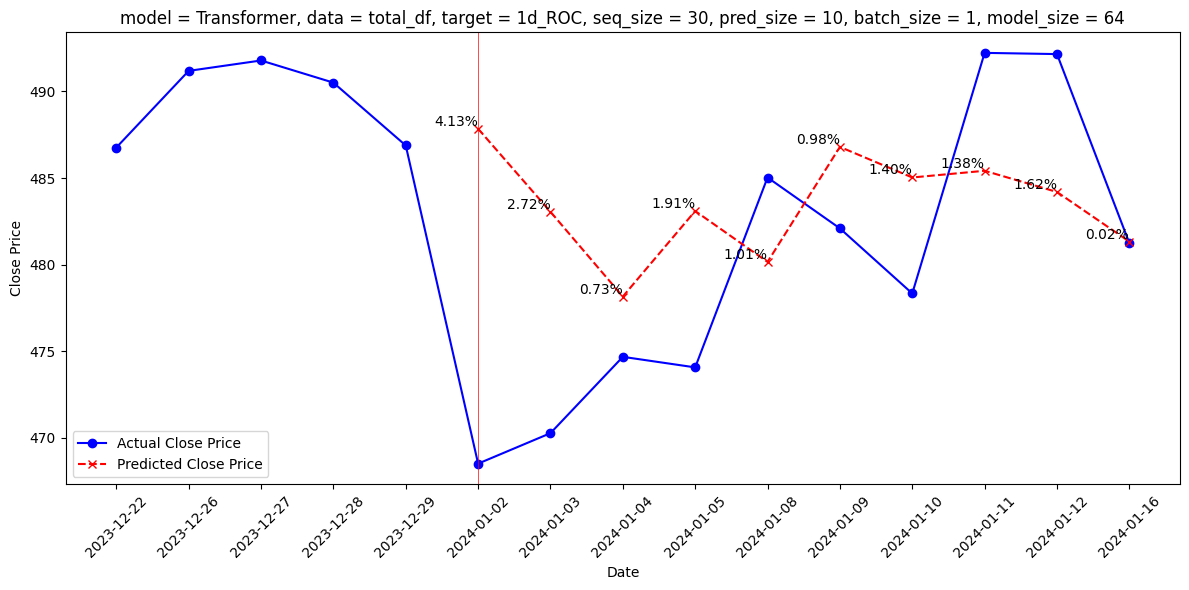

Average Error Rate: 1.59%


<Figure size 640x480 with 0 Axes>

In [10]:
# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d5_stock = stock_df.loc[d5_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d5_period+period, d5_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)
# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

    
plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {dataname}, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
# plt.savefig(f'../../plots/best_plots/10trials_{filename}.png') #### 본인 파일 경로
plt.show()
plt.clf()

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

print(f"Average Error Rate: {average_error_rate:.2f}%")
mean_error_ratios.append(average_error_rate)

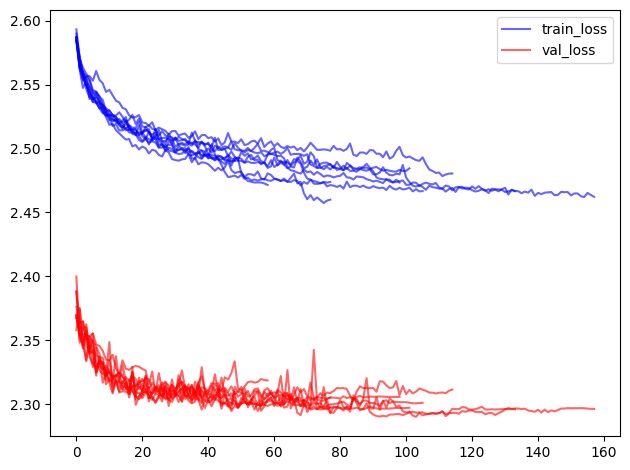

<Figure size 640x480 with 0 Axes>

In [11]:
### Visualize train-validation loss

for t in list(range(1,11)):
    plt.plot(range(len(globals()[f'train_losses_{t}'])),
             globals()[f'train_losses_{t}'],
             color='blue',alpha=0.6)
    plt.plot(range(len(globals()[f'val_losses_{t}'])),
             globals()[f'val_losses_{t}'],
             color='red',alpha=0.6)
plt.legend(['train_loss','val_loss'])
plt.tight_layout()
# plt.savefig(f'../../plots/best_plots/10trials_train_val_loss_{filename}.png')
plt.show()
plt.clf()